In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
import xarray as xr
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from netCDF4 import Dataset
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates
import matplotlib.patheffects as PathEffects

from cartopy.io import shapereader
import geopandas
import regionmask
from matplotlib.path import Path

ERROR 1: PROJ: proj_create_from_database: Open of /home/bwallace/.conda/envs/geo_env/share/proj failed


## Define cartopy projection and boundaries for subregions

In [2]:
wrf_native_coords=xr.open_dataset('data/wrf_coords.nc')
wrf_lat=wrf_native_coords.lat
wrf_lon=wrf_native_coords.lon

CESM_coords=xr.open_dataset('data/cesm_coords.nc')
CESM_lat=CESM_coords.lat
CESM_lon=CESM_coords.lon
CESM_lon,CESM_lat=np.meshgrid(CESM_lon,CESM_lat)

era_coords=xr.open_dataset('data/era_coords.nc')
era_lat=era_coords.lat
era_lon=era_coords.lon

# request data for use by geopandas
resolution = '110m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)
df=df[df.TYPE=='Country']
USA=df[df.SOV_A3=='US1']

shpfilename_lakes = shapereader.natural_earth('110m', 'physical', 'lakes')
lakes_df = geopandas.read_file(shpfilename_lakes)

lakes_df=lakes_df[lakes_df.name_alt=='Great Lakes']#.geometry

glakes_mask=regionmask.mask_geopandas(lakes_df.geometry,wrf_lon,wrf_lat)
glakes_mask_cesm=regionmask.mask_geopandas(lakes_df.geometry,CESM_lon,CESM_lat)
glakes_mask_era=regionmask.mask_geopandas(lakes_df.geometry,era_lon,era_lat)

usa_mask=regionmask.mask_geopandas(USA.geometry,wrf_lon,wrf_lat)
usa_mask_cesm=regionmask.mask_geopandas(USA.geometry,CESM_lon,CESM_lat)
usa_mask_era=regionmask.mask_geopandas(USA.geometry,era_lon,era_lat)

xy_points=np.vstack((wrf_lon.values.flatten(),wrf_lat.values.flatten())).T
xy_points_cesm=np.vstack((CESM_lon.flatten()-360,CESM_lat.flatten())).T #CESM lon is 360, so need to subtract
xy_points_era=np.vstack((era_lon.values.flatten(),era_lat.values.flatten())).T

vert_dict={}
vert_dict['sw']=[(-94.5,38),(-130,38),(-130,20),(-94.5,20)]
vert_dict['se']=[(-94.5,38),(-20,38),(-20,20),(-94.5,20)]
vert_dict['ne']=[(-81,38),(-20,38),(-20,50),(-81,50)]
vert_dict['mw']=[(-81,38),(-104,38),(-104,50),(-81,50)]
vert_dict['nr']=[(-104,38),(-121,38),(-121,50),(-104,50)]
vert_dict['nw']=[(-121,38),(-131,38),(-131,50),(-121,50)]

mask_dict={}
for key in vert_dict.keys():
    p=Path(vert_dict[key])
    grid=p.contains_points(xy_points)
    mask_dict[key]=grid.reshape(wrf_lat.shape)
    mask_dict[key]=xr.DataArray(mask_dict[key]).where(~np.isnan(usa_mask.values)).where(np.isnan(glakes_mask.values))
    mask_dict[key]=mask_dict[key].rename({'dim_0':'south_north','dim_1':'west_east'})
    
mask_cesm_dict={}
for key in vert_dict.keys():
    p=Path(vert_dict[key])
    grid=p.contains_points(xy_points_cesm)
    mask_cesm_dict[key]=grid.reshape(CESM_lat.shape)
    mask_cesm_dict[key]=xr.DataArray(mask_cesm_dict[key]).where(~np.isnan(usa_mask_cesm.values)).where(np.isnan(glakes_mask_cesm.values))
    mask_cesm_dict[key]=mask_cesm_dict[key].rename({'dim_0':'lat','dim_1':'lon'})
    
mask_era_dict={}
for key in vert_dict.keys():
    p=Path(vert_dict[key])
    grid=p.contains_points(xy_points_era)
    mask_era_dict[key]=grid.reshape(era_lat.shape)
    mask_era_dict[key]=xr.DataArray(mask_era_dict[key]).where(~np.isnan(usa_mask_era.values)).where(np.isnan(glakes_mask_era.values))
    mask_era_dict[key]=mask_era_dict[key].rename({'dim_0':'latitude','dim_1':'longitude'})

## Load in pre-averaged data

In [3]:
datasets={}
cesm_datasets={}
obs_datasets={}

for season in ['DJF','JJA','ALL']:

    datasets[season]={}
    path='data/wrf_native_6hly_avg_'+season+'.nc'
    datasets[season]['hist']=xr.open_dataset(path)
    path='data/wrf_native_6hly_avg_'+season+'_eoc8p5.nc'
    datasets[season]['eoc8p5']=xr.open_dataset(path)

    
for season in ['DJF','JJA','ALL']:
    cesm_datasets[season]={}
    path='data/CESM_6hly_avg_'+season+'.nc'
    cesm_datasets[season]['hist']=xr.open_dataset(path)
    path='data/CESM_6hly_avg_'+season+'_eoc8p5.nc'
    cesm_datasets[season]['eoc8p5']=xr.open_dataset(path)
    
for season in ['DJF','JJA','ALL']:
    obs_datasets[season]={}
    for obs in ['cmorph','stageiv','mswep']:
        obs_datasets[season][obs]={}
        path='data/obs_'+obs+'_6hly_avg_'+season+'.nc'
        obs_datasets[season][obs]=xr.open_dataset(path)
        
        obs_datasets[season]['median']=xr.concat([obs_datasets[season][entry] for entry in obs_datasets[season].keys()],dim='dataset')\
        .median('dataset')

## Get total grid cells per region to normalize precipitation amounts

In [4]:
total_cells={}
total_cells['wrf']={}
total_cells['cesm']={}
total_cells['era']={}
for region in mask_dict.keys():
    total_cells['wrf'][region]=mask_dict[region].where(mask_dict[region]==1).count()
    total_cells['cesm'][region]=mask_cesm_dict[region].where(mask_cesm_dict[region]==1).count()
    total_cells['era'][region]=mask_era_dict[region].where(mask_era_dict[region]==1).count()

wrf_count=xr.concat([total_cells['wrf'][entry] for entry in total_cells['wrf']],dim='region')
wrf_count=wrf_count.assign_coords({'region':list(mask_dict.keys())})

cesm_count=xr.concat([total_cells['cesm'][entry] for entry in total_cells['cesm']],dim='region')
cesm_count=cesm_count.assign_coords({'region':list(mask_cesm_dict.keys())})

era_count=xr.concat([total_cells['era'][entry] for entry in total_cells['era']],dim='region')
era_count=era_count.assign_coords({'region':list(mask_era_dict.keys())})

In [5]:
letters=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',\
        'a2','b2','c2','d2','e2','f2','g2']

unit_labels={
    'total_rain':'(mm cell$^{-1}$)',
    'num_total_events':'(# cells$^{-1}$)',
    'probability_rain':'()',
    'mean_intensity':'(mm 6hr$^{-1}$)'
}

## Plot decomposed historical precipitation for WRF

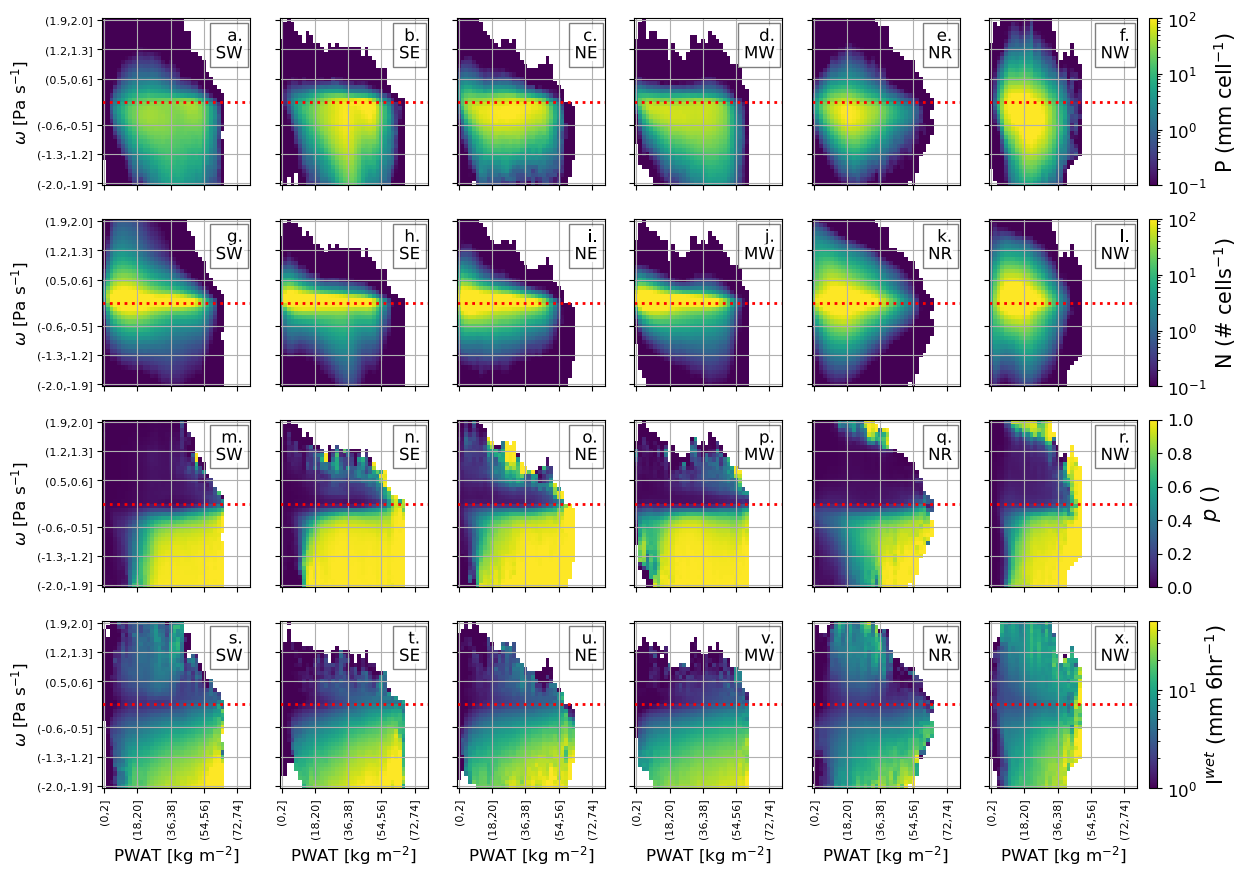

In [6]:
var_labels={
    'total_rain':'P',
    'num_total_events':'N',
    'probability_rain':'$p$',
    'mean_intensity':'I$^{wet}$'
}

omega_str='($\Delta^{2}_{p}$+'+r'$\frac{f^{2}}{\sigma}$'+r'$\frac{\delta^{2}}{\delta p^{2}}$) $\omega$'

season='ALL'
regions=list(datasets[season]['hist'].region)
var=list(datasets[season]['hist'].keys())

pwat_plot_bins=datasets[season]['hist'].pwat_bins.values
omega_plot_bins=datasets[season]['hist'].omega_bins.values

epoch='hist'

var_log={
    'total_rain':{
        'min':1e-1,
        'max':1e2,
    },
    'num_total_events':{
        'min':1e-1,
        'max':1e2,
    },
    'probability_rain':{
        'min':0,
        'max':1,
    },
    'mean_intensity':{
        'min':1,
        'max':5e1,
    },
}

fig,axs=plt.subplots(len(var),len(regions))
fig.set_figheight(10)
fig.set_figwidth(15)

nplot=0
for i in range(len(var)):
    for j in range(len(regions)):

        ax=axs[i,j]
        
        if var[i] not in ['probability_rain','mean_intensity']:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                datasets[season][epoch][var[i]].sel(region=regions[j]).T/wrf_count.sel(region=regions[j]),
                norm=colors.LogNorm(vmin=var_log[var[i]]['min'],vmax=var_log[var[i]]['max']),
            )
        elif var[i]=='probability_rain':
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                datasets[season][epoch][var[i]].sel(region=regions[j]).T,
                vmin=0,
                vmax=1,
            )
        elif var[i]=='mean_intensity':
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                datasets[season][epoch][var[i]].sel(region=regions[j]).T,
                norm=colors.LogNorm(vmin=var_log[var[i]]['min'],vmax=var_log[var[i]]['max']),
            )
            
        ax.set_xticks(range(len(pwat_plot_bins))[::9])
        ax.set_xticklabels(pwat_plot_bins[range(len(pwat_plot_bins))[::9]],rotation=90,fontsize=8)
        if i<len(var)-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('PWAT [kg m$^{-2}$]',fontsize=12)
        ax.set_yticks(np.append(np.arange(0,20,7),np.arange(25,40,7)))
        ax.set_yticklabels(omega_plot_bins[np.append(np.arange(0,20,7),np.arange(25,40,7))],fontsize=8)
        if j>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('$\omega$'+' [Pa s$^{-1}$]',fontsize=12)

            
        ax.axhline(len(omega_plot_bins)/2-0.5,color='r',linestyle=':',linewidth=2)
        
        t=ax.text(0.95,0.76,letters[nplot]+'.\n'+str(regions[j].values).upper(),
                  horizontalalignment='right',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

        if j==0:
            cbar_axs=[]
        cbar_axs.append(axs[i,j])
        if j==5:
            cbar=plt.colorbar(c,ax=cbar_axs,orientation='vertical',aspect=20,fraction=0.1,pad=0.01)
            cbar.set_label(var_labels[var[i]]+' '+unit_labels[var[i]],fontsize=15)
            cbar.ax.tick_params(labelsize=12)

        ax.grid()

        nplot+=1
        
plt.show()
plt.close()

## Plot decomposed historical precipitation for CESM

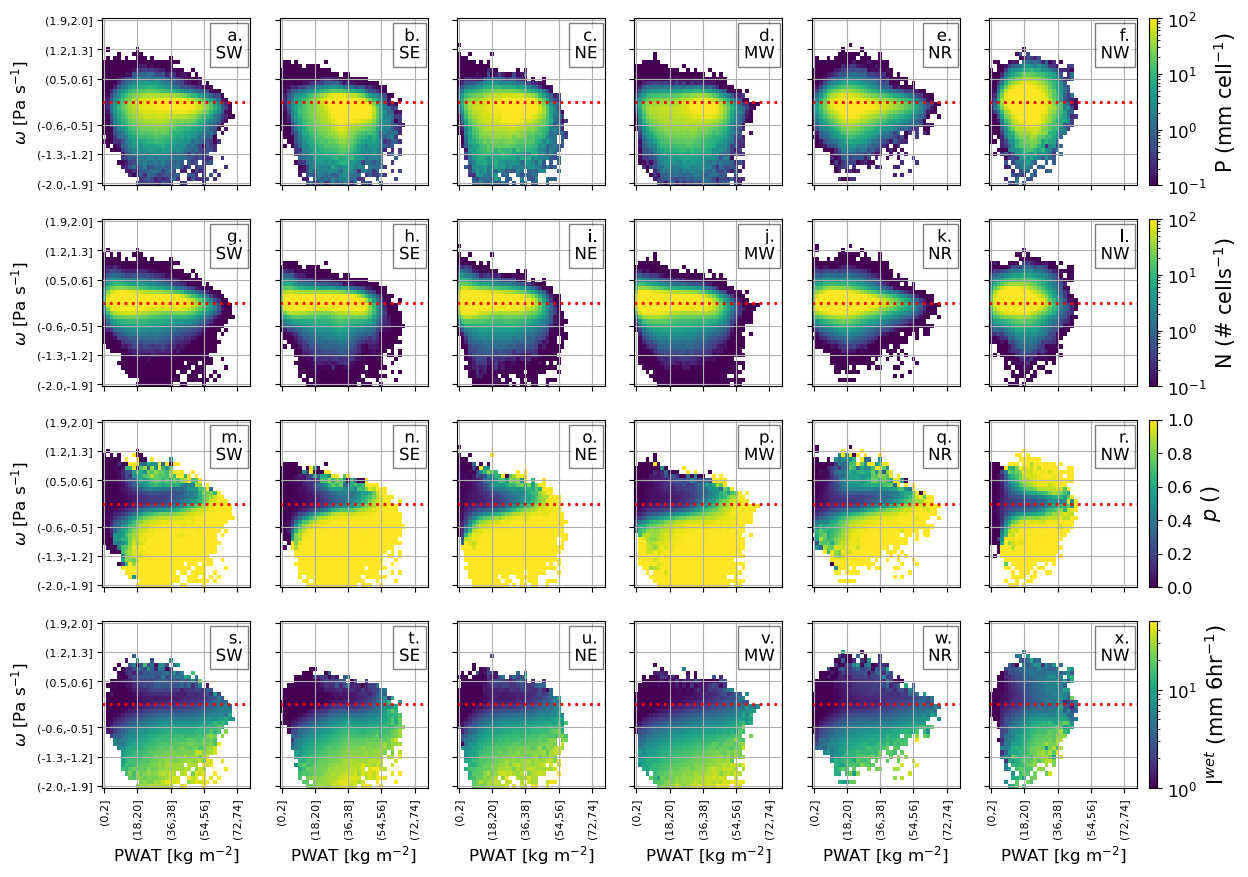

In [7]:
var_labels={
    'total_rain':'P',
    'num_total_events':'N',
    'probability_rain':'$p$',
    'mean_intensity':'I$^{wet}$'
}

omega_str='($\Delta^{2}_{p}$+'+r'$\frac{f^{2}}{\sigma}$'+r'$\frac{\delta^{2}}{\delta p^{2}}$) $\omega$'

season='ALL'
regions=list(datasets[season]['hist'].region)
var=list(datasets[season]['hist'].keys())

pwat_plot_bins=datasets[season]['hist'].pwat_bins.values
omega_plot_bins=datasets[season]['hist'].omega_bins.values

epoch='hist'

var_log={
    'total_rain':{
        'min':1e-1,
        'max':1e2,
    },
    'num_total_events':{
        'min':1e-1,
        'max':1e2,
    },
    'probability_rain':{
        'min':0,
        'max':1,
    },
    'mean_intensity':{
        'min':1,
        'max':5e1,
    },
}

fig,axs=plt.subplots(len(var),len(regions))
fig.set_figheight(10)
fig.set_figwidth(15)

nplot=0
for i in range(len(var)):
    for j in range(len(regions)):

        ax=axs[i,j]
        
        if var[i] not in ['probability_rain','mean_intensity']:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                cesm_datasets[season][epoch][var[i]].sel(region=regions[j]).T/cesm_count.sel(region=regions[j]),
                norm=colors.LogNorm(vmin=var_log[var[i]]['min'],vmax=var_log[var[i]]['max']),
            )
        elif var[i]=='probability_rain':
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                cesm_datasets[season][epoch][var[i]].sel(region=regions[j]).T,
                vmin=0,
                vmax=1,
            )
        elif var[i]=='mean_intensity':
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                cesm_datasets[season][epoch][var[i]].sel(region=regions[j]).T,
                norm=colors.LogNorm(vmin=var_log[var[i]]['min'],vmax=var_log[var[i]]['max']),
            )
        
        ax.set_xticks(range(len(pwat_plot_bins))[::9])
        ax.set_xticklabels(pwat_plot_bins[range(len(pwat_plot_bins))[::9]],rotation=90,fontsize=8)
        if i<len(var)-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('PWAT [kg m$^{-2}$]',fontsize=12)
        ax.set_yticks(np.append(np.arange(0,20,7),np.arange(25,40,7)))
        ax.set_yticklabels(omega_plot_bins[np.append(np.arange(0,20,7),np.arange(25,40,7))],fontsize=8)
        if j>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('$\omega$'+' [Pa s$^{-1}$]',fontsize=12)

            
        ax.axhline(len(omega_plot_bins)/2-0.5,color='r',linestyle=':',linewidth=2)
        
        t=ax.text(0.95,0.76,letters[nplot]+'.\n'+str(regions[j].values).upper(),
                  horizontalalignment='right',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

        if j==0:
            cbar_axs=[]
        cbar_axs.append(axs[i,j])
        if j==5:
            cbar=plt.colorbar(c,ax=cbar_axs,orientation='vertical',aspect=20,fraction=0.1,pad=0.01)
            cbar.set_label(var_labels[var[i]]+' '+unit_labels[var[i]],fontsize=15)
            cbar.ax.tick_params(labelsize=12)

        ax.grid()

        nplot+=1
        
plt.show()
plt.close()

## Calculate decomposition terms in the WRF - OBS & CESM - OBS comparisons

In [8]:
season='ALL'

PT_e_wrf_obs=(datasets[season]['hist'].total_rain/wrf_count)-\
(obs_datasets[season]['median'].total_rain/era_count)

delta_N_wrf_obs=(datasets[season]['hist'].num_total_events/wrf_count)-\
(obs_datasets[season]['median'].num_total_events/era_count)

delta_rho_wrf_obs=(datasets[season]['hist'].probability_rain)-\
(obs_datasets[season]['median'].probability_rain)

delta_I_wrf_obs=(datasets[season]['hist'].mean_intensity)-\
(obs_datasets[season]['median'].mean_intensity)

rho_o_wrf_obs=obs_datasets[season]['median'].probability_rain
N_o_wrf_obs=obs_datasets[season]['median'].num_total_events/era_count
I_o_wrf_obs=obs_datasets[season]['median'].mean_intensity

N_e_wrf_obs=delta_N_wrf_obs*rho_o_wrf_obs*I_o_wrf_obs
rho_e_wrf_obs=delta_rho_wrf_obs*I_o_wrf_obs*N_o_wrf_obs
I_e_wrf_obs=delta_I_wrf_obs*N_o_wrf_obs*rho_o_wrf_obs

R_e_wrf_obs=(delta_N_wrf_obs*delta_rho_wrf_obs*I_o_wrf_obs)+\
(delta_rho_wrf_obs*delta_I_wrf_obs*N_o_wrf_obs)+\
(delta_I_wrf_obs*delta_N_wrf_obs*rho_o_wrf_obs)+\
(delta_rho_wrf_obs*delta_I_wrf_obs*delta_N_wrf_obs)

In [9]:
season='ALL'

PT_e_cesm_obs=(cesm_datasets[season]['hist'].total_rain/cesm_count)-\
(obs_datasets[season]['median'].total_rain/era_count)

delta_N_cesm_obs=(cesm_datasets[season]['hist'].num_total_events/cesm_count)-\
(obs_datasets[season]['median'].num_total_events/era_count)

delta_rho_cesm_obs=(cesm_datasets[season]['hist'].probability_rain)-\
(obs_datasets[season]['median'].probability_rain)

delta_I_cesm_obs=(cesm_datasets[season]['hist'].mean_intensity)-\
(obs_datasets[season]['median'].mean_intensity)

rho_o_cesm_obs=obs_datasets[season]['median'].probability_rain
N_o_cesm_obs=obs_datasets[season]['median'].num_total_events/era_count
I_o_cesm_obs=obs_datasets[season]['median'].mean_intensity

N_e_cesm_obs=delta_N_cesm_obs*rho_o_cesm_obs*I_o_cesm_obs
rho_e_cesm_obs=delta_rho_cesm_obs*I_o_cesm_obs*N_o_cesm_obs
I_e_cesm_obs=delta_I_cesm_obs*N_o_cesm_obs*rho_o_cesm_obs

R_e_cesm_obs=(delta_N_cesm_obs*delta_rho_cesm_obs*I_o_cesm_obs)+\
(delta_rho_cesm_obs*delta_I_cesm_obs*N_o_cesm_obs)+\
(delta_I_cesm_obs*delta_N_cesm_obs*rho_o_cesm_obs)+\
(delta_rho_cesm_obs*delta_I_cesm_obs*delta_N_cesm_obs)

## Plot WRF-OBS decomposition 

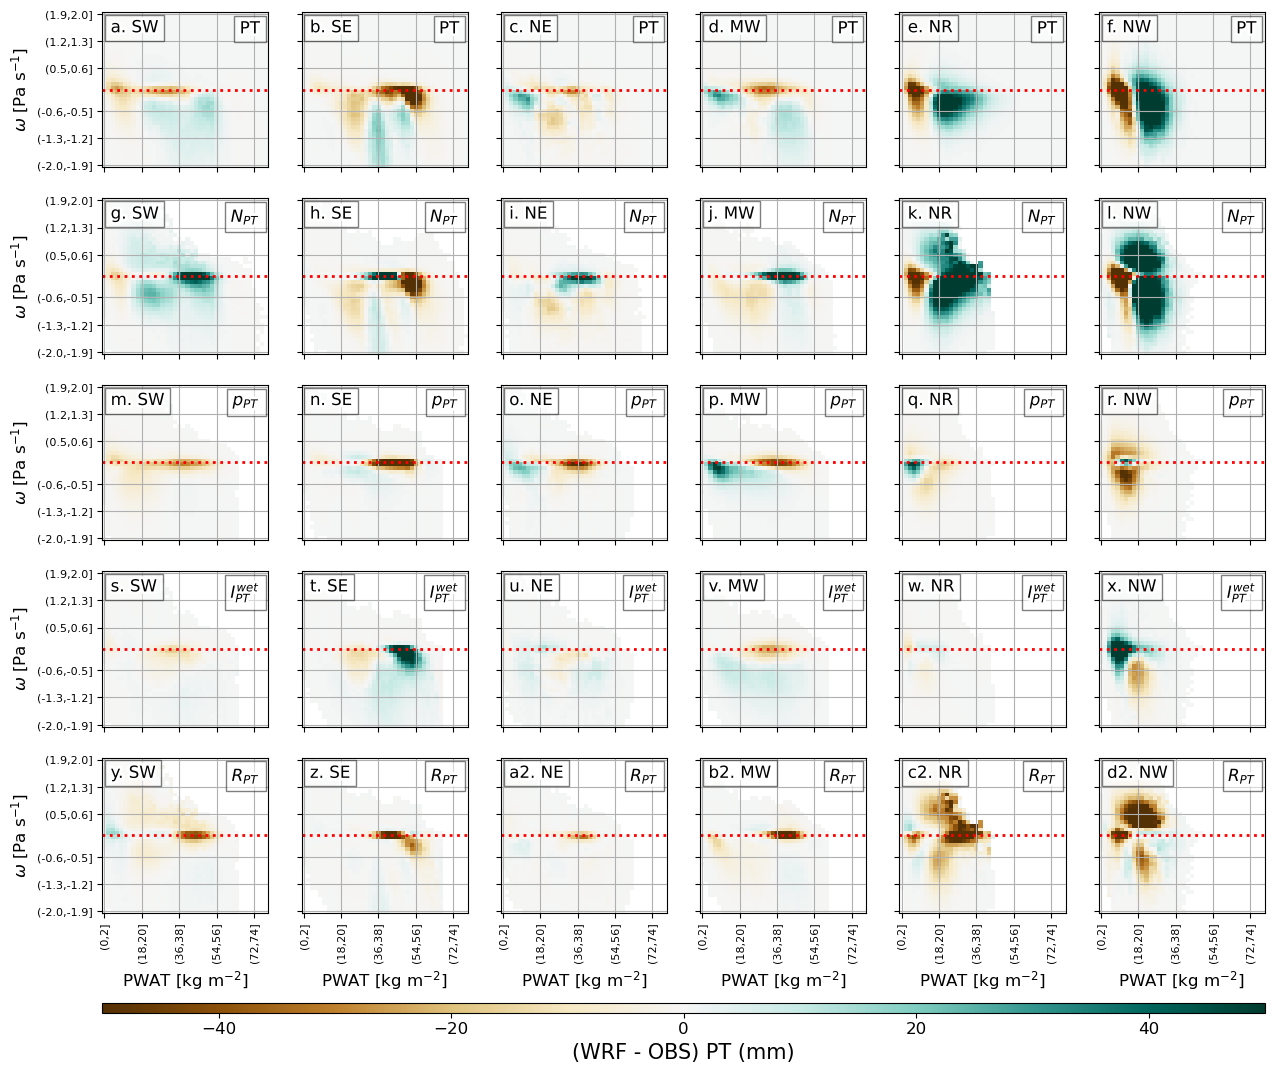

In [10]:
var_labels={
    'total_rain':'PT',
    'num_total_events':'$N_{PT}$',
    'probability_rain':'$p_{PT}$',
    'mean_intensity':'$I_{PT}^{wet}$',
    'residual_terms':'$R_{PT}$',
}

omega_str='($\Delta^{2}_{p}$+'+r'$\frac{f^{2}}{\sigma}$'+r'$\frac{\delta^{2}}{\delta p^{2}}$) $\omega$'

regions=list(datasets[season]['hist'].region)
var=list(datasets[season]['hist'].keys())
if 'total_cells' in var:
    var.remove('total_cells')

pwat_plot_bins=datasets[season]['hist'].pwat_bins.values
omega_plot_bins=datasets[season]['hist'].omega_bins.values

PT_min=-5e1
PT_max=5e1

fig,axs=plt.subplots(5,len(regions))
fig.set_figheight(13)
fig.set_figwidth(15)

nplot=0
for i in range(5):
    for j in range(len(regions)):

        ax=axs[i,j]
        
        if i==0:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                PT_e_wrf_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==1:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                N_e_wrf_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==2:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                rho_e_wrf_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==3:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                I_e_wrf_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==4:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                R_e_wrf_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
            
            
        ax.set_xticks(range(len(pwat_plot_bins))[::9])
        ax.set_xticklabels(pwat_plot_bins[range(len(pwat_plot_bins))[::9]],rotation=90,fontsize=8)
        if i<4:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('PWAT [kg m$^{-2}$]',fontsize=12)
        ax.set_yticks(np.append(np.arange(0,20,7),np.arange(25,40,7)))
        ax.set_yticklabels(omega_plot_bins[np.append(np.arange(0,20,7),np.arange(25,40,7))],fontsize=8)
        if j>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('$\omega$'+' [Pa s$^{-1}$]',fontsize=12)

            
        ax.axhline(len(omega_plot_bins)/2-0.5,color='r',linestyle=':',linewidth=2)
        
        t=ax.text(0.05,0.87,letters[nplot]+'. '+str(regions[j].values).upper(),
                  horizontalalignment='left',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))
        t=ax.text(0.95,0.94,var_labels[list(var_labels.keys())[i]],
                  horizontalalignment='right',verticalalignment='top',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

        if i==0 and j==0:
            cbar_axs=[]
        cbar_axs.append(ax)

        ax.grid()

        nplot+=1
        
cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=120,fraction=0.01,pad=0.09)
cbar.set_label('(WRF - OBS) '+var_labels['total_rain']+' (mm)',fontsize=15)
cbar.ax.tick_params(labelsize=12)

plt.show()
plt.close()

## Plot CESM - OBS decomposition

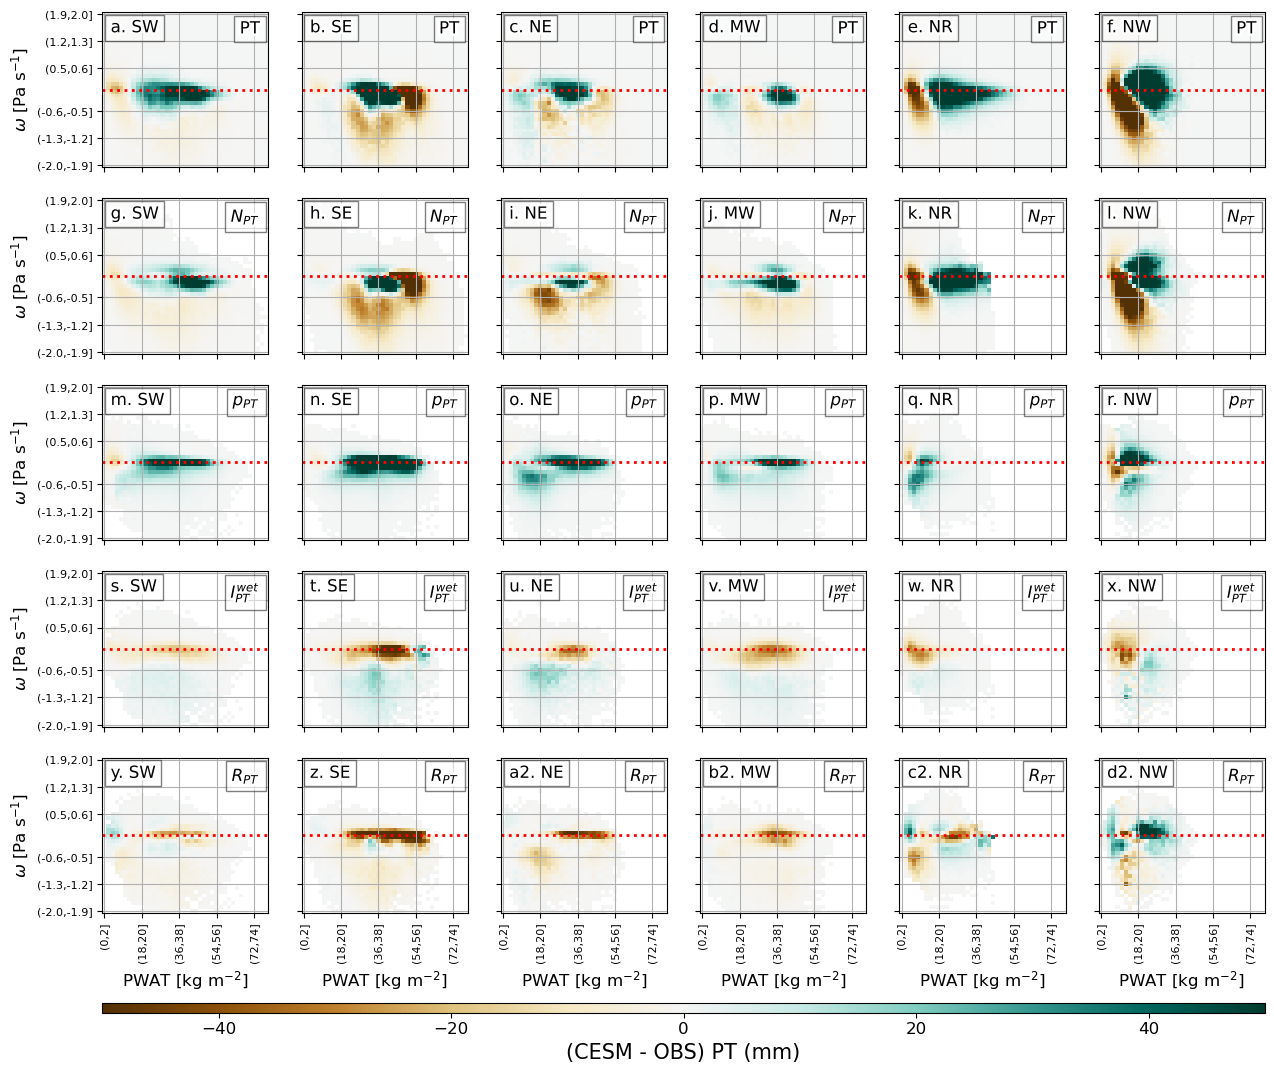

In [11]:
var_labels={
    'total_rain':'PT',
    'num_total_events':'$N_{PT}$',
    'probability_rain':'$p_{PT}$',
    'mean_intensity':'$I_{PT}^{wet}$',
    'residual_terms':'$R_{PT}$',
}

omega_str='($\Delta^{2}_{p}$+'+r'$\frac{f^{2}}{\sigma}$'+r'$\frac{\delta^{2}}{\delta p^{2}}$) $\omega$'

regions=list(datasets[season]['hist'].region)
var=list(datasets[season]['hist'].keys())
if 'total_cells' in var:
    var.remove('total_cells')

pwat_plot_bins=datasets[season]['hist'].pwat_bins.values
omega_plot_bins=datasets[season]['hist'].omega_bins.values

PT_min=-5e1
PT_max=5e1

fig,axs=plt.subplots(5,len(regions))
fig.set_figheight(13)
fig.set_figwidth(15)

nplot=0
for i in range(5):
    for j in range(len(regions)):

        ax=axs[i,j]
        
        if i==0:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                PT_e_cesm_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==1:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                N_e_cesm_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==2:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                rho_e_cesm_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==3:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                I_e_cesm_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==4:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                R_e_cesm_obs.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
            
            
        ax.set_xticks(range(len(pwat_plot_bins))[::9])
        ax.set_xticklabels(pwat_plot_bins[range(len(pwat_plot_bins))[::9]],rotation=90,fontsize=8)
        if i<4:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('PWAT [kg m$^{-2}$]',fontsize=12)
        ax.set_yticks(np.append(np.arange(0,20,7),np.arange(25,40,7)))
        ax.set_yticklabels(omega_plot_bins[np.append(np.arange(0,20,7),np.arange(25,40,7))],fontsize=8)
        if j>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('$\omega$'+' [Pa s$^{-1}$]',fontsize=12)

            
        ax.axhline(len(omega_plot_bins)/2-0.5,color='r',linestyle=':',linewidth=2)
        
        t=ax.text(0.05,0.87,letters[nplot]+'. '+str(regions[j].values).upper(),
                  horizontalalignment='left',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))
        t=ax.text(0.95,0.94,var_labels[list(var_labels.keys())[i]],
                  horizontalalignment='right',verticalalignment='top',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

        if i==0 and j==0:
            cbar_axs=[]
        cbar_axs.append(ax)

        ax.grid()

        nplot+=1
        
cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=120,fraction=0.01,pad=0.09)
cbar.set_label('(CESM - OBS) '+var_labels['total_rain']+' (mm)',fontsize=15)
cbar.ax.tick_params(labelsize=12)

plt.show()
plt.close()

## Plot normalized absolute & absolute additive errors for WRF & CESM against observations

/tmp/ipykernel_63004/1726495648.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Southwest','Southwest','Southeast','Northeast','Midwest','Northern Rockies','Northwest'],
/tmp/ipykernel_63004/1726495648.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Southwest','Southwest','Southeast','Northeast','Midwest','Northern Rockies','Northwest'],


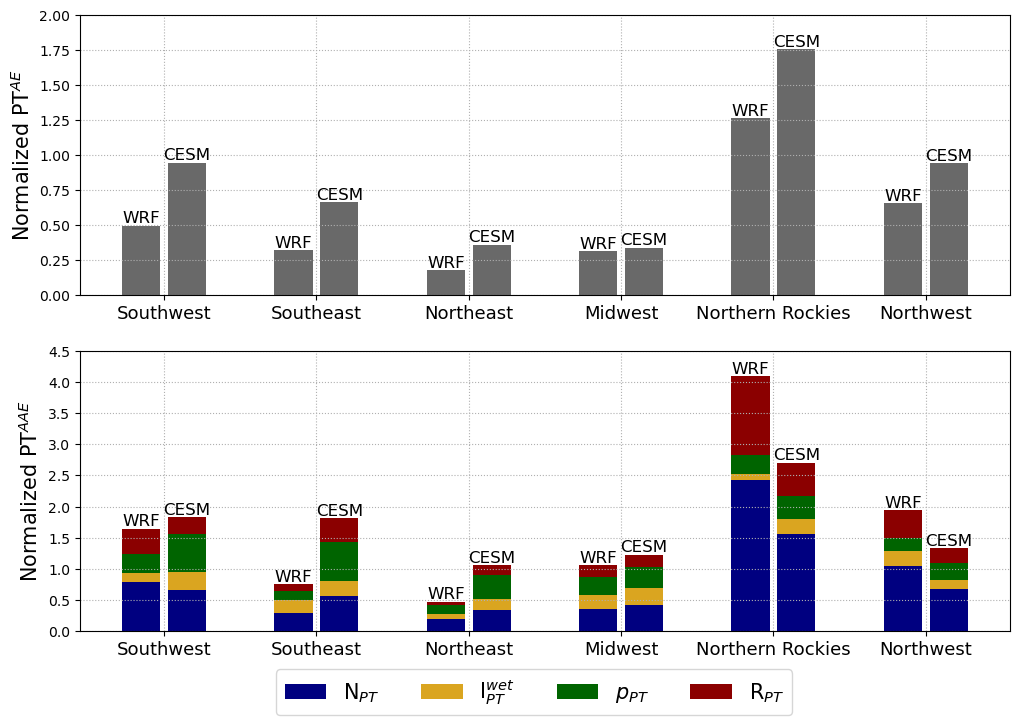

In [12]:
regions=list(datasets[season]['hist'].region)

fig,axs=plt.subplots(2,1)
fig.set_figheight(8)
fig.set_figwidth(12)



region=(
    'Southwest',
    'Southeast',
    'Northeast',
    'Midwest',
    'Northern Rockies',
    'Northwest'
)

weights={
    'N$_{PT}$':[abs(N_e_wrf_obs.sel(region=region)).sum().values for region in regions],
    'I$_{PT}^{wet}$':[abs(I_e_wrf_obs.sel(region=region)).sum().values for region in regions],
    '$p_{PT}$':[abs(rho_e_wrf_obs.sel(region=region)).sum().values for region in regions],
    'R$_{PT}$':[abs(R_e_wrf_obs.sel(region=region)).sum().values for region in regions],
}
weights_cesm={
    'N$_{PT}$':[abs(N_e_cesm_obs.sel(region=region)).sum().values for region in regions],
    'I$_{PT}^{wet}$':[abs(I_e_cesm_obs.sel(region=region)).sum().values for region in regions],
    '$p_{PT}$':[abs(rho_e_cesm_obs.sel(region=region)).sum().values for region in regions],
    'R$_{PT}$':[abs(R_e_cesm_obs.sel(region=region)).sum().values for region in regions],
}

x=np.arange(len(regions))

ax=axs[0]
p=ax.bar(x-0.15,abs(PT_e_wrf_obs).sum(dim=('pwat_bins','omega_bins'))/obs_datasets['ALL']['median'].total_rain.sum(('pwat_bins','omega_bins'))*\
        era_count,
        0.25,color='dimgray')
ax.bar_label(p,labels=['WRF','WRF','WRF','WRF','WRF','WRF'],label_type='edge',fontsize=12)

p=ax.bar(x+0.15,abs(PT_e_cesm_obs).sum(dim=('pwat_bins','omega_bins'))/obs_datasets['ALL']['median'].total_rain.sum(('pwat_bins','omega_bins'))*\
        era_count,
        0.25,color='dimgray')
ax.bar_label(p,labels=['CESM','CESM','CESM','CESM','CESM','CESM'],label_type='edge',fontsize=12)

ax.set_xticklabels(['Southwest','Southwest','Southeast','Northeast','Midwest','Northern Rockies','Northwest'],
                  fontsize=13)

ax.set_ylabel('Normalized PT$^{AE}$',fontsize=15)
ax.set_ylim(0,2)

ax.grid(linestyle=':')

ax=axs[1]

bottom=np.zeros(len(regions))
bottom_cesm=np.zeros(len(regions))


width=0.25
multiplier=0
offset=width*multiplier

color={
    'N$_{PT}$':'navy',
    'I$_{PT}^{wet}$':'goldenrod',
    '$p_{PT}$':'darkgreen',
    'R$_{PT}$':'darkred',
}
    

for boolean,weight_count in weights.items():
    offset=width*multiplier
    
    p=ax.bar(x-0.15,weight_count/obs_datasets['ALL']['median'].total_rain.sum(('pwat_bins','omega_bins'))*\
             [era_count.sel(region=region) for region in regions],
             width,label=boolean,bottom=bottom,color=color[boolean])
    bottom+=weight_count/obs_datasets['ALL']['median'].total_rain.sum(('pwat_bins','omega_bins'))*\
             [era_count.sel(region=region) for region in regions]
        
    if boolean=='R$_{PT}$':
        ax.bar_label(p,labels=['WRF','WRF','WRF','WRF','WRF','WRF'],label_type='edge',fontsize=12)

    p=ax.bar(x+0.15,weights_cesm[boolean]/obs_datasets['ALL']['median'].total_rain.sum(('pwat_bins','omega_bins'))*\
             [era_count.sel(region=region) for region in regions],
             width,bottom=bottom_cesm,color=color[boolean])
    bottom_cesm+=weights_cesm[boolean]/obs_datasets['ALL']['median'].total_rain.sum(('pwat_bins','omega_bins'))*\
             [era_count.sel(region=region) for region in regions]
    
    if boolean=='R$_{PT}$':
        ax.bar_label(p,labels=['CESM','CESM','CESM','CESM','CESM','CESM'],label_type='edge',fontsize=12)

ax.set_xticklabels(['Southwest','Southwest','Southeast','Northeast','Midwest','Northern Rockies','Northwest'],
                  fontsize=13)
    
ax.legend(loc='upper left',bbox_to_anchor=(0.2,-0.1),ncol=4,fontsize=15)
ax.grid(linestyle=':')

ax.set_ylabel('Normalized PT$^{AAE}$',fontsize=15)
ax.set_ylim(0,4.5)
    
plt.show()
plt.close()

## Perform decomposition on June-August precipitation difference between EoC85 and HIST for WRF and CESM

In [13]:
season='JJA'

PT_e_wrf=datasets[season]['eoc8p5'].total_rain/wrf_count-\
datasets[season]['hist'].total_rain/wrf_count

delta_N_wrf=datasets[season]['eoc8p5'].num_total_events/wrf_count-\
datasets[season]['hist'].num_total_events/wrf_count
delta_rho_wrf=datasets[season]['eoc8p5'].probability_rain-datasets[season]['hist'].probability_rain
delta_I_wrf=datasets[season]['eoc8p5'].mean_intensity-datasets[season]['hist'].mean_intensity

rho_o_wrf=datasets[season]['hist'].probability_rain
N_o_wrf=datasets[season]['hist'].num_total_events/wrf_count
I_o_wrf=datasets[season]['hist'].mean_intensity

N_e_wrf=delta_N_wrf*rho_o_wrf*I_o_wrf
rho_e_wrf=delta_rho_wrf*N_o_wrf*I_o_wrf
I_e_wrf=delta_I_wrf*N_o_wrf*rho_o_wrf

R_e_wrf=(delta_N_wrf*delta_rho_wrf*I_o_wrf)+\
(delta_rho_wrf*delta_I_wrf*N_o_wrf)+\
(delta_I_wrf*delta_N_wrf*rho_o_wrf)+\
(delta_rho_wrf*delta_I_wrf*delta_N_wrf)


PT_e_cesm=cesm_datasets[season]['eoc8p5'].total_rain/cesm_count-\
cesm_datasets[season]['hist'].total_rain/cesm_count

delta_N_cesm=cesm_datasets[season]['eoc8p5'].num_total_events/cesm_count-\
cesm_datasets[season]['hist'].num_total_events/cesm_count
delta_rho_cesm=cesm_datasets[season]['eoc8p5'].probability_rain-cesm_datasets[season]['hist'].probability_rain
delta_I_cesm=cesm_datasets[season]['eoc8p5'].mean_intensity-cesm_datasets[season]['hist'].mean_intensity

rho_o_cesm=cesm_datasets[season]['hist'].probability_rain
N_o_cesm=cesm_datasets[season]['hist'].num_total_events/cesm_count
I_o_cesm=cesm_datasets[season]['hist'].mean_intensity

N_e_cesm=delta_N_cesm*rho_o_cesm*I_o_cesm
rho_e_cesm=delta_rho_cesm*N_o_cesm*I_o_cesm
I_e_cesm=delta_I_cesm*N_o_cesm*rho_o_cesm

R_e_cesm=(delta_N_cesm*delta_rho_cesm*I_o_cesm)+\
(delta_rho_cesm*delta_I_cesm*N_o_cesm)+\
(delta_I_cesm*delta_N_cesm*rho_o_cesm)+\
(delta_rho_cesm*delta_I_cesm*delta_N_cesm)

## Plot WRF EoC85-HIST Decomposition

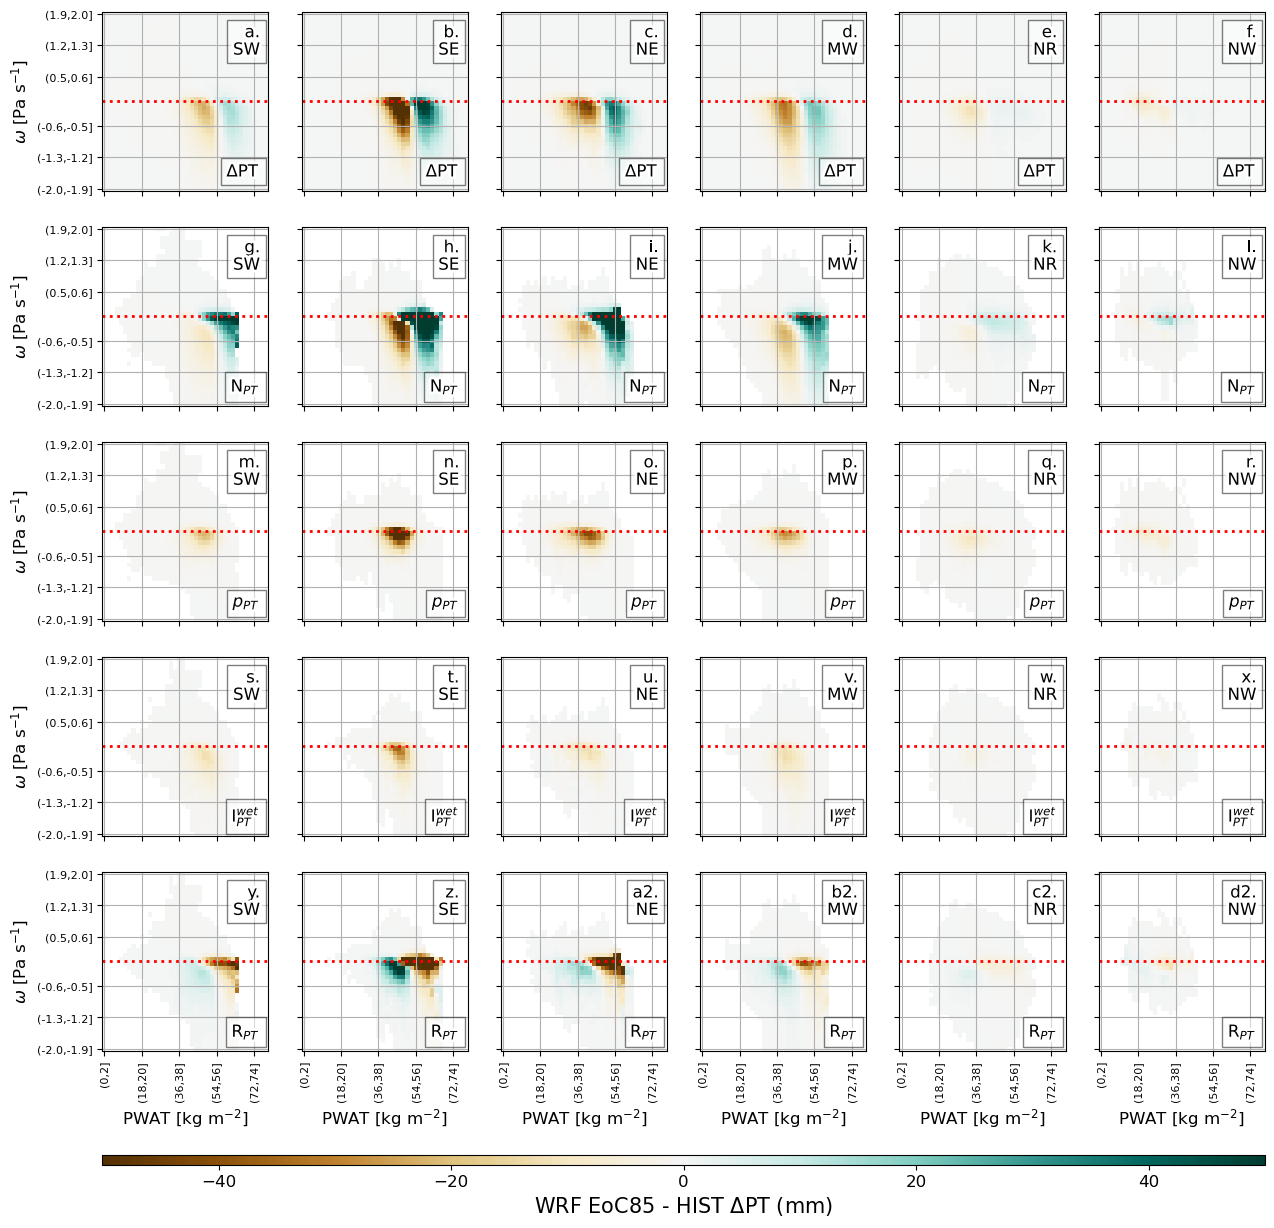

In [14]:
var=[
    'total_rain',
    'num_total_events',
    'probability_rain',
    'mean_intensity',
    'residual_terms'
]

var_labels={
    'total_rain':'$\Delta$PT',
    'num_total_events':'N$_{PT}$',
    'probability_rain':'$p_{PT}$',
    'mean_intensity':'I$_{PT}^{wet}$',
    'residual_terms':'R$_{PT}$',
}

omega_str='($\Delta^{2}_{p}$+'+r'$\frac{f^{2}}{\sigma}$'+r'$\frac{\delta^{2}}{\delta p^{2}}$) $\omega$'

regions=list(datasets[season]['hist'].region)
if 'total_cells' in var:
    var.remove('total_cells')

pwat_plot_bins=datasets[season]['hist'].pwat_bins.values
omega_plot_bins=datasets[season]['hist'].omega_bins.values

PT_min=-5e1
PT_max=5e1

fig,axs=plt.subplots(len(var),len(regions))
fig.set_figheight(15)
fig.set_figwidth(15)

nplot=0
for i in range(len(var)):
    for j in range(len(regions)):

        ax=axs[i,j]
        
        if i==0:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                PT_e_wrf.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==1:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                N_e_wrf.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==2:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                rho_e_wrf.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==3:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                I_e_wrf.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==4:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                R_e_wrf.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )

            
        ax.set_xticks(range(len(pwat_plot_bins))[::9])
        ax.set_xticklabels(pwat_plot_bins[range(len(pwat_plot_bins))[::9]],rotation=90,fontsize=8)
        if i<len(var)-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('PWAT [kg m$^{-2}$]',fontsize=12)
        ax.set_yticks(np.append(np.arange(0,20,7),np.arange(25,40,7)))
        ax.set_yticklabels(omega_plot_bins[np.append(np.arange(0,20,7),np.arange(25,40,7))],fontsize=8)
        if j>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('$\omega$'+' [Pa s$^{-1}$]',fontsize=12)

            
        ax.axhline(len(omega_plot_bins)/2-0.5,color='r',linestyle=':',linewidth=2)
        
        t=ax.text(0.95,0.76,letters[nplot]+'.\n'+str(regions[j].values).upper(),
                  horizontalalignment='right',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))
        t=ax.text(0.95,0.08,var_labels[var[i]],
                  horizontalalignment='right',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

        ax.grid()

        nplot+=1
        
        if i==0 and j==0:
            cbar_axs=[]
        cbar_axs.append(ax)
        
cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=120,fraction=0.01,pad=0.09)
cbar.set_label('WRF EoC85 - HIST $\Delta$PT (mm)',fontsize=15)
cbar.ax.tick_params(labelsize=12)

plt.show()
plt.close()

## Plot CESM EoC85 - HIST decomposition

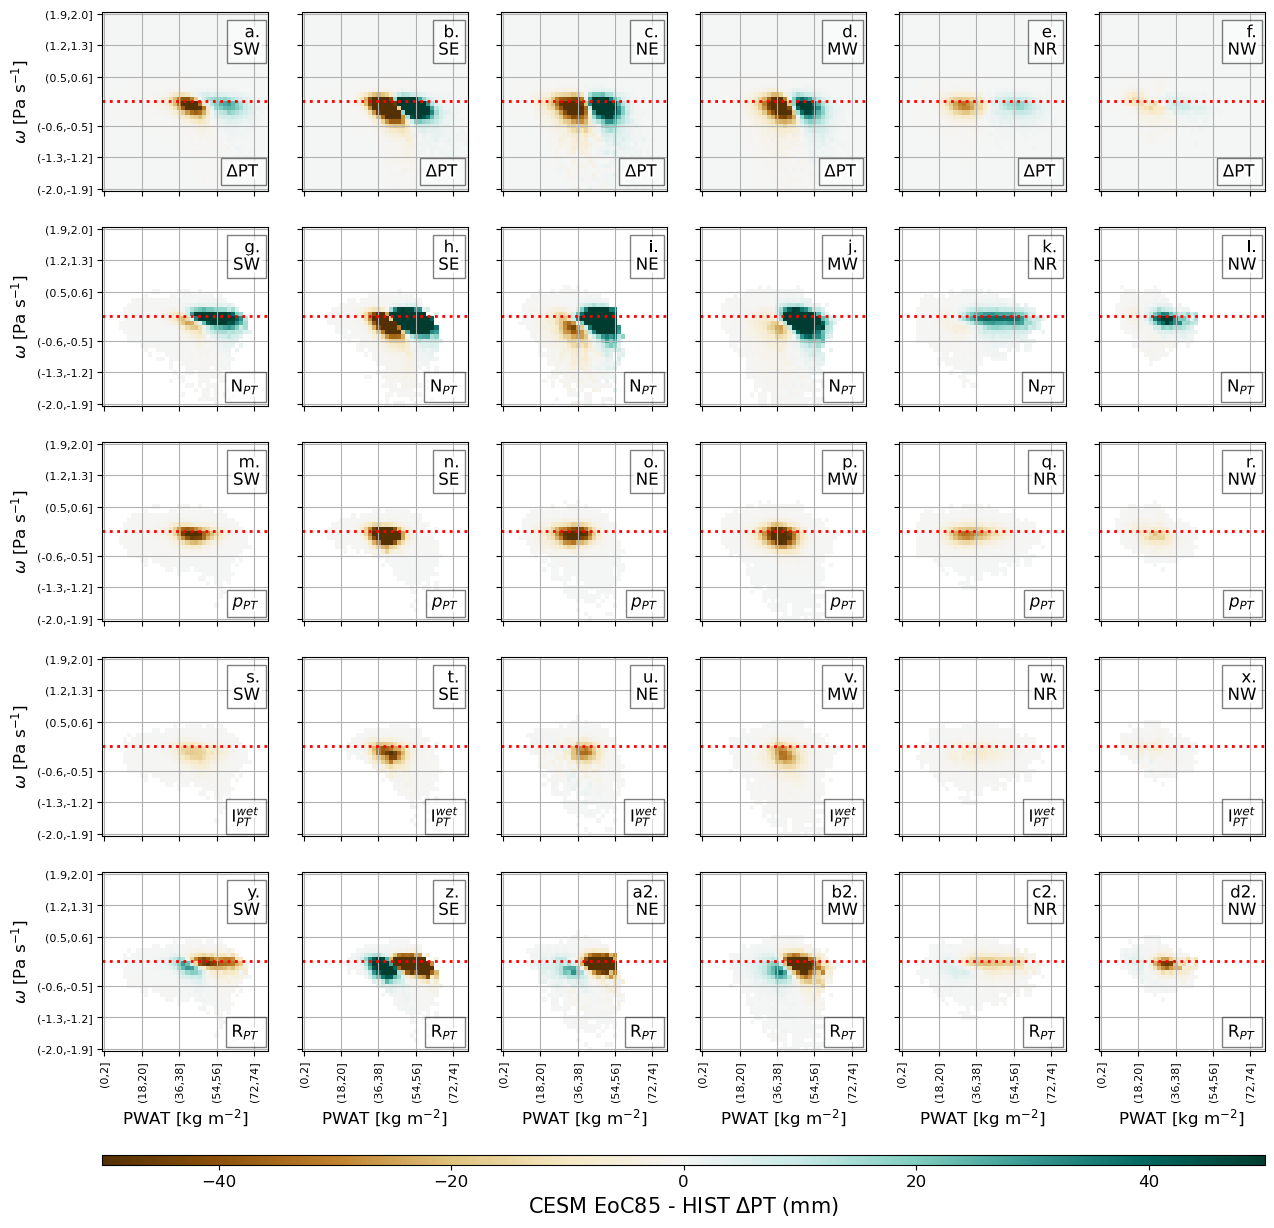

In [15]:
var=[
    'total_rain',
    'num_total_events',
    'probability_rain',
    'mean_intensity',
    'residual_terms'
]

var_labels={
    'total_rain':'$\Delta$PT',
    'num_total_events':'N$_{PT}$',
    'probability_rain':'$p_{PT}$',
    'mean_intensity':'I$_{PT}^{wet}$',
    'residual_terms':'R$_{PT}$',
}

omega_str='($\Delta^{2}_{p}$+'+r'$\frac{f^{2}}{\sigma}$'+r'$\frac{\delta^{2}}{\delta p^{2}}$) $\omega$'

regions=list(datasets[season]['hist'].region)
if 'total_cells' in var:
    var.remove('total_cells')

pwat_plot_bins=datasets[season]['hist'].pwat_bins.values
omega_plot_bins=datasets[season]['hist'].omega_bins.values

PT_min=-5e1
PT_max=5e1

fig,axs=plt.subplots(len(var),len(regions))
fig.set_figheight(15)
fig.set_figwidth(15)

nplot=0
for i in range(len(var)):
    for j in range(len(regions)):

        ax=axs[i,j]
        
        if i==0:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                PT_e_cesm.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==1:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                N_e_cesm.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==2:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                rho_e_cesm.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==3:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                I_e_cesm.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )
        elif i==4:
            c=ax.pcolormesh(
                pwat_plot_bins,
                omega_plot_bins,
                R_e_cesm.sel(region=regions[j]).T,
                vmin=PT_min,vmax=PT_max,
                cmap='BrBG',
            )

            
        ax.set_xticks(range(len(pwat_plot_bins))[::9])
        ax.set_xticklabels(pwat_plot_bins[range(len(pwat_plot_bins))[::9]],rotation=90,fontsize=8)
        if i<len(var)-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel('PWAT [kg m$^{-2}$]',fontsize=12)
        ax.set_yticks(np.append(np.arange(0,20,7),np.arange(25,40,7)))
        ax.set_yticklabels(omega_plot_bins[np.append(np.arange(0,20,7),np.arange(25,40,7))],fontsize=8)
        if j>0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('$\omega$'+' [Pa s$^{-1}$]',fontsize=12)

            
        ax.axhline(len(omega_plot_bins)/2-0.5,color='r',linestyle=':',linewidth=2)
        
        t=ax.text(0.95,0.76,letters[nplot]+'.\n'+str(regions[j].values).upper(),
                  horizontalalignment='right',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))
        t=ax.text(0.95,0.08,var_labels[var[i]],
                  horizontalalignment='right',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))

        ax.grid()

        nplot+=1
        
        if i==0 and j==0:
            cbar_axs=[]
        cbar_axs.append(ax)
        
cbar=plt.colorbar(c,ax=cbar_axs,orientation='horizontal',aspect=120,fraction=0.01,pad=0.09)
cbar.set_label('CESM EoC85 - HIST $\Delta$PT (mm)',fontsize=15)
cbar.ax.tick_params(labelsize=12)

        
plt.show()
plt.close()

## Sum up decomposition terms across all $\omega$ regimes

In [16]:
sum_error_wrf=(N_e_wrf+I_e_wrf+rho_e_wrf+R_e_wrf)

PT_e_wrf_pwat_breakdown=PT_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='omega_bins')
N_e_wrf_pwat_breakdown=N_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='omega_bins')
I_e_wrf_pwat_breakdown=I_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='omega_bins')
rho_e_wrf_pwat_breakdown=rho_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='omega_bins')
R_e_wrf_pwat_breakdown=R_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='omega_bins')

PT_e_wrf_omega_breakdown=PT_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='pwat_bins')
N_e_wrf_omega_breakdown=N_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='pwat_bins')
I_e_wrf_omega_breakdown=I_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='pwat_bins')
rho_e_wrf_omega_breakdown=rho_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='pwat_bins')
R_e_wrf_omega_breakdown=R_e_wrf.where(~np.isnan(sum_error_wrf)).sum(dim='pwat_bins')

In [17]:
sum_error_cesm=(N_e_cesm+I_e_cesm+rho_e_cesm+R_e_cesm)

PT_e_cesm_pwat_breakdown=PT_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='omega_bins')
N_e_cesm_pwat_breakdown=N_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='omega_bins')
I_e_cesm_pwat_breakdown=I_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='omega_bins')
rho_e_cesm_pwat_breakdown=rho_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='omega_bins')
R_e_cesm_pwat_breakdown=R_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='omega_bins')

PT_e_cesm_omega_breakdown=PT_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='pwat_bins')
N_e_cesm_omega_breakdown=N_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='pwat_bins')
I_e_cesm_omega_breakdown=I_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='pwat_bins')
rho_e_cesm_omega_breakdown=rho_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='pwat_bins')
R_e_cesm_omega_breakdown=R_e_cesm.where(~np.isnan(sum_error_cesm)).sum(dim='pwat_bins')

## Plot summed decomposition terms for WRF

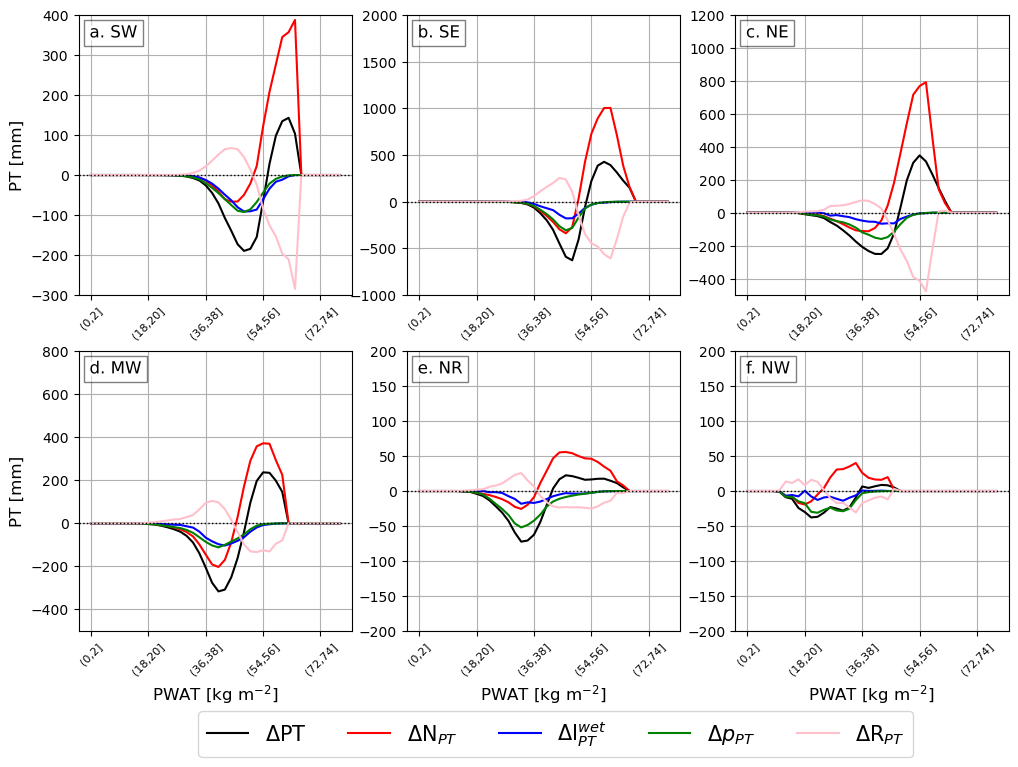

In [18]:
xlabel_dict={
    'sw':(-300,400),
    'se':(-1000,2000),
    'ne':(-500,1200),
    'mw':(-500,800),
    'nr':(-200,200),
    'nw':(-200,200)
}

regions=list(mask_dict.keys())
pwat_plot_bins=PT_e_wrf_pwat_breakdown.pwat_bins.values

fig,axs=plt.subplots(2,3)
fig.set_figheight(8)
fig.set_figwidth(12)

num=0
for i in range(2):
    for j in range(3):
        
        ax=axs[i,j]
        ax.plot(PT_e_wrf_pwat_breakdown.sel(region=regions[num]),color='k',label='$\Delta$PT')
        ax.plot(N_e_wrf_pwat_breakdown.sel(region=regions[num]),color='r',label='$\Delta$N$_{PT}$')
        ax.plot(I_e_wrf_pwat_breakdown.sel(region=regions[num]),color='blue',label='$\Delta$I$^{wet}_{PT}$')
        ax.plot(rho_e_wrf_pwat_breakdown.sel(region=regions[num]),color='g',label='$\Delta$$p_{PT}$')
        ax.plot(R_e_wrf_pwat_breakdown.sel(region=regions[num]),color='pink',label='$\Delta$R$_{PT}$')

        ax.grid()
        t=ax.text(0.04,0.92,letters[num]+'. '+str(regions[num]).upper(),
                  horizontalalignment='left',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))
        ax.set_xticks(range(len(pwat_plot_bins))[::9])
        ax.set_xticklabels(pwat_plot_bins[range(len(pwat_plot_bins))[::9]],rotation=45,fontsize=8)
        ax.set_ylim(xlabel_dict[regions[num]])
        ax.axhline(y=0,color='k',linestyle=':',linewidth=1)
        
        if j==0:
            ax.set_ylabel('PT [mm]',fontsize=12)
        if i==1:
            ax.set_xlabel('PWAT [kg m$^{-2}$]',fontsize=12)


        num+=1
        
axs[-1,-1].legend(loc='upper left',bbox_to_anchor=(-2,-0.25),ncol=5,fontsize=15)
plt.show()
plt.close()

## Plot summed decomposition terms for CESM

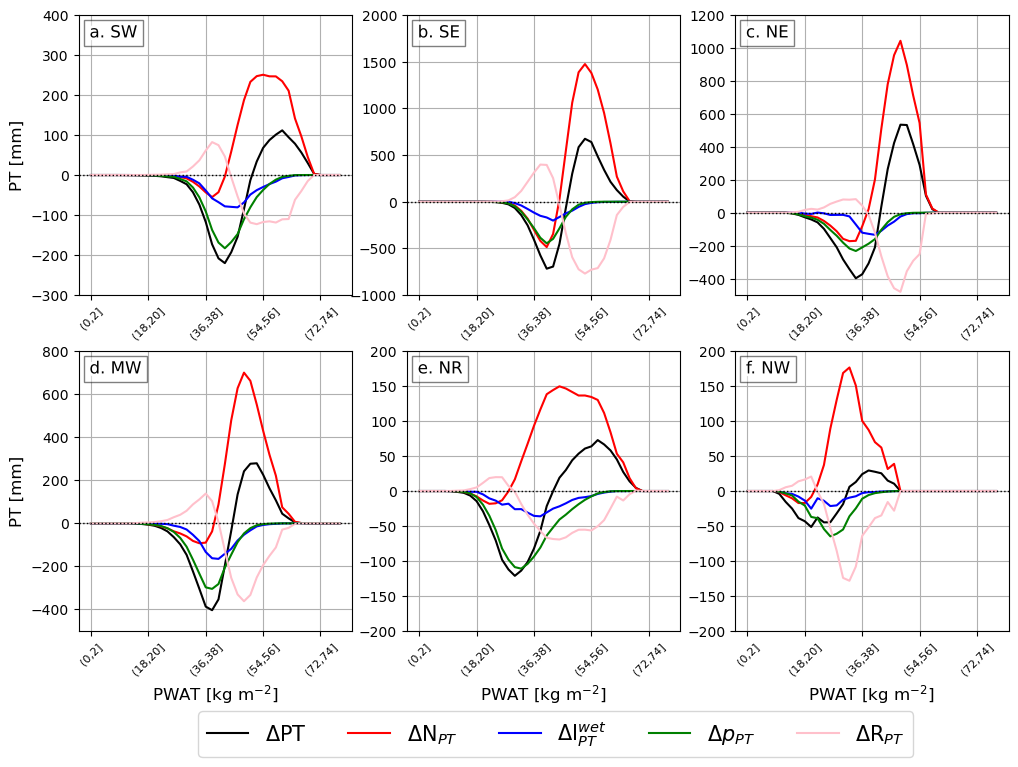

In [19]:
regions=list(mask_dict.keys())
pwat_plot_bins=PT_e_cesm_pwat_breakdown.pwat_bins.values

fig,axs=plt.subplots(2,3)
fig.set_figheight(8)
fig.set_figwidth(12)

num=0
for i in range(2):
    for j in range(3):
        
        ax=axs[i,j]
        ax.plot(PT_e_cesm_pwat_breakdown.sel(region=regions[num]),color='k',label='$\Delta$PT')
        
        ax.plot(N_e_cesm_pwat_breakdown.sel(region=regions[num]),color='r',label='$\Delta$N$_{PT}$')

        ax.plot(I_e_cesm_pwat_breakdown.sel(region=regions[num]),color='blue',label='$\Delta$I$^{wet}_{PT}$')
        ax.plot(rho_e_cesm_pwat_breakdown.sel(region=regions[num]),color='g',label='$\Delta$$p_{PT}$')
        ax.plot(R_e_cesm_pwat_breakdown.sel(region=regions[num]),color='pink',label='$\Delta$R$_{PT}$')

        ax.grid()
        t=ax.text(0.04,0.92,letters[num]+'. '+str(regions[num]).upper(),
                  horizontalalignment='left',
                  size=12,color='k',
                  path_effects=[PathEffects.withStroke(linewidth=4,foreground='white')],
                  transform=ax.transAxes)
        t.set_bbox(dict(facecolor='white',alpha=0.5,edgecolor='black'))
        ax.set_xticks(range(len(pwat_plot_bins))[::9])
        ax.set_xticklabels(pwat_plot_bins[range(len(pwat_plot_bins))[::9]],rotation=45,fontsize=8)
        ax.set_ylim(xlabel_dict[regions[num]])
        ax.axhline(y=0,color='k',linestyle=':',linewidth=1)
        
        if j==0:
            ax.set_ylabel('PT [mm]',fontsize=12)
        if i==1:
            ax.set_xlabel('PWAT [kg m$^{-2}$]',fontsize=12)


        num+=1
        
axs[-1,-1].legend(loc='upper left',bbox_to_anchor=(-2,-0.25),ncol=5,fontsize=15)
plt.show()
plt.close()